In [81]:
import pandas as pd
import spacy
import numpy as np
import sys

nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import wordnet
from nltk.corpus import wordnet_ic
nltk.download('wordnet')
nltk.download('wordnet_ic')
ic_brown = wordnet_ic.ic('ic-brown.dat')

from nltk import ngrams
from nltk.metrics import jaccard_distance
from nltk.wsd import lesk

nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

from random import sample
from sklearn.ensemble import RandomForestRegressor
from statistics import mean
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

[nltk_data] Downloading package wordnet to /home/mauro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /home/mauro/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/mauro/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


# Features

## Basic Features

In [30]:
def ratio_of_number_of_tokens(tokenized_sentence1, tokenized_sentence2):
    """Given two tokenized sentences, return the ratio of the number of tokens between them"""
    return min(len(tokenized_sentence1), len(tokenized_sentence2))/max(len(tokenized_sentence1), len(tokenized_sentence2))

In [31]:
def ratio_of_number_of_characters(sentence1, sentence2):
    """Given two strings, return the ratio of the number of characters between them"""
    # Dani: same here, I changed this to the ratio instead of the diff
    return min(len(sentence1), len(sentence2)) / max(len(sentence1), len(sentence2))

## Jaccard Similarities

In [32]:
# Tokens
def get_jaccard_similarity(sentence1,sentence2):
    """Returns Jaccard similarity between sentences"""
    return 1-jaccard_distance(set(sentence1), set(sentence2))

## Semantic Features

In [33]:
similarity_methods = {
    "wu-palmer": lambda s1, s2: s1.wup_similarity(s2),
    "path": lambda s1, s2: s1.path_similarity(s2),
    "leacock": lambda s1, s2: s1.lch_similarity(s2),
    "lin": lambda s1, s2: s1.lin_similarity(s2, ic_brown)
}

In [34]:
def get_wordnet_pos(category):
    """
    Convert a POS tag from the Spacy tagset to the WordNet tagset.
    """
    if category.startswith('J'):
        return 'a'  # Adjective
    elif category.startswith('V'):
        return 'v'  # Verb
    elif category.startswith('N'):
        return 'n'  # Noun
    elif (category.startswith('R')) and (category != 'RP'):
        # I looked into the RP tag is for particles
        return 'r'  # Adverb
    else:
        return None  # WordNet doesn't handle other POS tags

In [35]:
cache = {}
def get_best_synset_pair(word1, word2, pos, similarity, similarity_type):
    """
    Get the best synset pair for two words.

    This function gets the best synset pair for two words, considering every possible pair of synsets from the two words. The best pair is the one with the highest similarity score.

    Parameters:
    - word1: The first word, represented as a Spacy token.
    - word2: The second word, represented as a Spacy token.
    - pos: A string indicating the part of speech of the words.
    - similarity: A function to calculate the similarity between two synsets.
    - similarity_type: A string indicating the name of the similarity measure.

    Returns:
    - A float representing the similarity score of the best synset pair.
    """
    # Create a cache key (I do this because it is simetric and to save time)
    cache_key = tuple(sorted([word1.text, word2.text]) + [similarity_type]) 
    if cache_key in cache:
        return cache[cache_key]

    synsets_word1 = wordnet.synsets(word1.text, pos=pos)
    synsets_word2 = wordnet.synsets(word2.text, pos=pos)
    max_sim = 0

    for synset1 in synsets_word1:
        for synset2 in synsets_word2:
            # We skip the satellite adjectives (gives problems for Lin and Leacock)
            if synset1.pos() == 's' or synset2.pos() == 's':
                continue
            sim = similarity(synset1, synset2)
            if sim and sim > max_sim:
                max_sim = sim
    
    cache[cache_key] = max_sim
    # If there is no similarity, we return 0
    return max_sim

In [36]:
def get_sentence_similarities(sentence1, sentence2, similarity_type):
    """
    Calculate the similarity between two sentences using a specified similarity measure.

    For each sentence, the function gets the best similarity value for each word considering every posible pair, using words from the other sentence. Then the mean of this similarities is computed over the sentence and the output is the mean similarity of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a list of tokens.
    - sentence2: The second sentence, represented as a list of tokens.
    - similarity_type: A string indicating the type of similarity measure to use. 
        Options include "wu-palmer", "path", "leacock", and "lin".

    Returns:
    - A float representing the average similarity score between the two sentences.
    """
    # TODO: Judge if we want to normalize by the number of words that have a valid POS for WordNet (current implementation)
    # Do it for sentence1
    similarity1 = 0
    den = 0 # We will normalize by the number of words that have a valid POS for WordNet
    for token1 in sentence1:
        similarities = np.array([])
        pos1 = get_wordnet_pos(token1.tag_)
        if not pos1:
            continue
        den +=1
        for token2 in sentence2:
            pos2 = get_wordnet_pos(token2.tag_)
            if (not pos2) or (pos1 != pos2):
                continue
            similarities = np.append(similarities,get_best_synset_pair(token1, token2, pos1, similarity_methods[similarity_type], similarity_type))
        if similarities.size > 0:
            similarity1 += np.max(similarities)
    # We average the similarity (even if they don't get a similarity)
    similarity1 = similarity1 / den

    # Do it for sentence2
    similarity2 = 0
    den = 0 # We will normalize by the number of words that have a valid POS for WordNet
    for token2 in sentence2:
        similarities = np.array([])
        pos2 = get_wordnet_pos(token2.tag_)
        if not pos2:
            continue
        den +=1
        for token1 in sentence1:
            pos1 = get_wordnet_pos(token1.tag_)
            if (not pos1) or (pos1 != pos2):
                continue
            similarities = np.append(similarities, get_best_synset_pair(token1, token2, pos2, similarity_methods[similarity_type], similarity_type))
        if similarities.size > 0:
            similarity2 += np.max(similarities)
    # We average the similarity (even if they don't get a similarity)
    similarity2 = similarity2 / den
    
    return np.mean(np.array([similarity1, similarity2]))

In [96]:
def lesk_jaccard_similarity(sentence1,sentence2):
    """
    Returns the Lesk similarity between sentences
    
    Parameters:
    - sentence1: The first sentence, represented as a list of tokens.
    - sentence2: The second sentence, represented as a list of tokens.

    Returns:
    - A float representing the Jaccard similarity between the best synsets of the two sentences, according to the Lesk algorithm.
    """
    synsets1 = [lesk(sentence1, token.text, get_wordnet_pos(token.tag_)) for token in sentence1]
    synsets2 = [lesk(sentence2, token.text, get_wordnet_pos(token.tag_)) for token in sentence2]
    if len(synsets1) == 0 or len(synsets2) == 0:
        return 0
    return 1 - jaccard_distance(set(synsets1), set(synsets2))

In [97]:
def sentiwordnet_correlation(sentence1,sentence2,method='pos'):
    """
    This function calculates the absolute difference between the average sentiment scores of the lesk synsets of the two sentences, normalized by the maximum value of the sentiment score.

    Parameters:
    - sentence1: The first sentence, represented as a list of tokens.
    - sentence2: The second sentence, represented as a list of tokens.
    - method: A string indicating the type of sentiment score to use. 
        Options include "pos", "neg", and "obj".

    Returns:
    - A float representing the difference in the mean sentiment scores of the two sentences, normalized by the maximum value of the sentiment score.
    """
    synsets1 = [lesk(sentence1, token.text, get_wordnet_pos(token.tag_)) for token in sentence1]
    synsets2 = [lesk(sentence2, token.text, get_wordnet_pos(token.tag_)) for token in sentence2]
    
    sentisynsets1 = [swn.senti_synset(synset.name()) for synset in synsets1 if synset is not None]
    sentisynsets2 = [swn.senti_synset(synset.name()) for synset in synsets2 if synset is not None]

    if len(sentisynsets1) == 0 or len(sentisynsets2) == 0:
        return 0

    if method == 'pos':
        mean1 = mean([sentiSynset.pos_score() for sentiSynset in sentisynsets1])
        mean2 = mean([sentiSynset.pos_score() for sentiSynset in sentisynsets2])
        if mean1 == 0 and mean2 == 0:
            return abs(mean1 - mean2)
        return abs(mean1 - mean2)/max(mean1, mean2)
    elif method == 'neg':
        mean1 = mean([sentiSynset.neg_score() for sentiSynset in sentisynsets1])
        mean2 = mean([sentiSynset.neg_score() for sentiSynset in sentisynsets2])
        if mean1 == 0 and mean2 == 0:
            return abs(mean1 - mean2)
        return abs(mean1 - mean2)/max(mean1, mean2)
    elif method == 'obj':
        mean1 = mean([sentiSynset.obj_score() for sentiSynset in sentisynsets1])
        mean2 = mean([sentiSynset.obj_score() for sentiSynset in sentisynsets2])
        if mean1 == 0 and mean2 == 0:
            return abs(mean1 - mean2)
        return abs(mean1 - mean2)/max(mean1, mean2)
    else:
        raise ValueError("Error: this method is not supported")

## N-Grams

### Word N-Grams Features

In [37]:
def get_ngram_similarity(sentence1, sentence2, n):
    """
    Calculate the similarity between two sentences using n-grams.

    This function calculates the similarity between two sentences using n-grams. The similarity is calculated as the jaccard similarity between the set of n-grams of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a list of tokens.
    - sentence2: The second sentence, represented as a list of tokens.
    - n: The size of the n-grams to use.

    Returns:
    - A float representing the Jaccard similarity between the two sentences.
    """
    ngrams1 = set([str(x) for x in ngrams(sentence1,n)])
    ngrams2 = set([str(x) for x in ngrams(sentence2,n)])
    # Some sentences have less than n words, so we need to check if the ngrams are empty
    if len(ngrams1) == 0 and len(ngrams2) == 0:
        return 1
    return 1-jaccard_distance(ngrams1,ngrams2)

### Character N-Gram Features

In [38]:
def get_character_ngram_similarity(sentence1, sentence2, n):
    """
    Calculate the similarity between two sentences using character n-grams.

    This function calculates the similarity between two sentences using character n-grams. The similarity is calculated as the jaccard similarity between the set of n-grams of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a string
    - sentence2: The second sentence, represented as a string.
    - n: The size of the n-grams to use.

    Returns:
    - A float representing the Jaccard similarity between the two sentences.
    """
    ngrams1 = set([str(x) for x in ngrams(sentence1,n)])
    ngrams2 = set([str(x) for x in ngrams(sentence2,n)])

    return 1-jaccard_distance(ngrams1,ngrams2)

# Function to get all of the features

In [88]:
def get_features (df):

    features = pd.DataFrame()
    for rowindex, row in df.iterrows():
        features.at[rowindex, 'token_ratio'] = ratio_of_number_of_tokens(row['0_nlp'], row['1_nlp'])
        features.at[rowindex, 'char_ratio'] = ratio_of_number_of_characters(row["0_lower"], row["1_lower"])
        features.at[rowindex, 'jaccard_similarity_tokens'] = get_jaccard_similarity([token.text for token in row["0_nlp"]], [token.text for token in row["1_nlp"]])
        features.at[rowindex, 'jaccard_similarity_tokens_no_stops'] = get_jaccard_similarity([token.text for token in row["0_nlp_no_stop"]], [token.text for token in row["1_nlp_no_stop"]])
        features.at[rowindex, 'jaccard_similarity_lemmas'] = get_jaccard_similarity(row["0_lemma"], row["1_lemma"])
        features.at[rowindex, 'jaccard_similarity_lemmas_no_stops'] = get_jaccard_similarity(row["0_lemma_no_stop"], row["1_lemma_no_stop"])
        features.at[rowindex, 'wu-palmer_similarity'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "wu-palmer")
        #df.at[rowindex, 'lin_similarity'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "lin")
        features.at[rowindex, 'path_similarity'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "path")
        features.at[rowindex, 'leacock_similarity'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "leacock")
        features.at[rowindex, 'lesk_jaccard_similarity'] = lesk_jaccard_similarity(row["0_nlp"], row["1_nlp"])
        features.at[rowindex, 'bigram_similarity'] = get_ngram_similarity(row["0_nlp"], row["1_nlp"], 2)
        features.at[rowindex, 'trigram_similarity'] = get_ngram_similarity(row["0_nlp"], row["1_nlp"], 3)
        features.at[rowindex, 'quadgram_similarity'] = get_ngram_similarity(row["0_nlp"], row["1_nlp"], 4)
        features.at[rowindex, 'lemma_bigram_similarity'] = get_ngram_similarity(row["0_lemma"], row["1_lemma"], 2)
        features.at[rowindex, 'lemma_trigram_similarity'] = get_ngram_similarity(row["0_lemma"], row["1_lemma"], 3)
        features.at[rowindex, 'lemma_quadgram_similarity'] = get_ngram_similarity(row["0_lemma"], row["1_lemma"], 4)
        features.at[rowindex, 'char_bigram_similarity'] = get_character_ngram_similarity(row["0_lower"], row["1_lower"], 2)
        features.at[rowindex, 'char_trigram_similarity'] = get_character_ngram_similarity(row["0_lower"], row["1_lower"], 3)
        features.at[rowindex, 'char_quadgram_similarity'] = get_character_ngram_similarity(row["0_lower"], row["1_lower"], 4)
        features.at[rowindex, 'sentiwordnet_pos_difference'] = sentiwordnet_correlation(row["0_nlp"], row["1_nlp"], 'pos')
        features.at[rowindex, 'sentiwordnet_neg_difference'] = sentiwordnet_correlation(row["0_nlp"], row["1_nlp"], 'neg')
        features.at[rowindex, 'sentiwordnet_obj_difference'] = sentiwordnet_correlation(row["0_nlp"], row["1_nlp"], 'obj')
    return features

### Lin

Apparently, in wordnet there is another postag, 'r', that stands for satellite adjective. This doesn't cause problems with wu-palmer, probably because they share the same synsets as they say here:

"Adjectives are arranged in clusters containing head synsets and satellite synsets. Each cluster is organized around antonymous pairs (and occasionally antonymous triplets). The antonymous pairs (or triplets) are indicated in the head synsets of a cluster. Most head synsets have one or more satellite synsets, each of which represents a concept that is similar in meaning to the concept represented by the head synset. One way to think of the adjective cluster organization is to visualize a wheel, with a head synset as the hub and satellite synsets as the spokes. Two or more wheels are logically connected via antonymy, which can be thought of as an axle between the wheels." from https://wordnet.princeton.edu/documentation/wngloss7wn

The thing is, for some reason this is not allowed when computing lin_similarity. This could be due to some requirements in the use of information from an annotated corpus. I have tried brown and semcor and none work. I could manually remove this, but I want to know why this happens. It stops with:
"nltk.corpus.reader.wordnet.WordNetError: Computing the least common subsumer requires Synset('autochthonal.s.01') and Synset('whole.a.01') to have the same part of speech."

The mistake says, to compute the least common subsumer it is required to have the same pos tag, but wu-palmer also needs the least common subsummer and it doesn't give any error. I looked into this and there is not information online (some links are broken) and most code snippets don't even consider the 'r' class when they are iterating over synsets. 

In the end, we did not use lin similarity because semcor and brown corpus apparently do not allow the pos tag 'r' and 'a' from adverbs and adjctives.

# Preprocesing

In [40]:
def preprocessing(sentences):
    """Processes the sentences to get the features"""
    # Words (it may have numbers)
    sentences["0_lower"] = sentences[0].apply(lambda x: ''.join([char.lower() if not char.isdigit() else char for char in x]))
    sentences["1_lower"] = sentences[1].apply(lambda x: ''.join([char.lower() if not char.isdigit() else char for char in x]))

    # Tokens
    sentences["0_nlp"] = sentences["0_lower"].apply(lambda x: nlp(x))
    sentences["1_nlp"] = sentences["1_lower"].apply(lambda x: nlp(x))
    # Filter out stop words
    sentences["0_nlp_no_stop"] = sentences["0_nlp"].apply(lambda x: [token for token in x if not token.is_stop])
    sentences["1_nlp_no_stop"] = sentences["1_nlp"].apply(lambda x: [token for token in x if not token.is_stop])

    # Lemmas
    sentences['0_lemma'] = sentences['0_nlp'].apply(lambda x: [token.lemma for token in x])
    sentences['1_lemma'] = sentences['1_nlp'].apply(lambda x: [token.lemma for token in x])
    # Filter out stop words
    sentences['0_lemma_no_stop'] = sentences['0_nlp_no_stop'].apply(lambda x: [token.lemma for token in x])
    sentences['1_lemma_no_stop'] = sentences['1_nlp_no_stop'].apply(lambda x: [token.lemma for token in x])
    return sentences

In [41]:
# Function to read and clean data, tracking bad line indices
def read_and_clean_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cleaned_lines = []
    bad_line_indices = []
    for i, line in enumerate(lines):
        fields = line.strip().split('\t')
        if len(fields) == 2:
            cleaned_lines.append(fields)
        else:
            print(f"Skipping bad line: {line.strip()}")
            bad_line_indices.append(i)

    return pd.DataFrame(cleaned_lines, columns=[0, 1]), bad_line_indices

## Training

In [100]:
# Load the train data
sentences_file_paths = [
    "../Data/Train/train/STS.input.SMTeuroparl.txt",
    "../Data/Train/train/STS.input.MSRvid.txt",
    "../Data/Train/train/STS.input.MSRpar.txt",
    ]
gold_standard_file_paths = [
    "../Data/Train/train/STS.gs.SMTeuroparl.txt",
    "../Data/Train/train/STS.gs.MSRvid.txt",
    "../Data/Train/train/STS.gs.MSRpar.txt",
    ]   

# Read and clean the data files into DataFrames, tracking bad line indices
sentences_list = []
bad_line_indices_list = []
for path in sentences_file_paths:
    df, bad_line_indices = read_and_clean_data(path)
    sentences_list.append(df)
    bad_line_indices_list.append(bad_line_indices)

sentences_training: pd.DataFrame = pd.concat(sentences_list, ignore_index=True)

gs_list = [pd.read_csv(path, header=None) for path in gold_standard_file_paths]
# Remove the rows that correspond to bad lines
for i, gs in enumerate(gs_list):
    gs = gs.drop(bad_line_indices_list[i])
gs_training: pd.DataFrame = pd.concat(gs_list, ignore_index=True)

# Preprocess the sentences
sentences_training = preprocessing(sentences_training)

In [101]:
# Get the features
features_training = get_features(sentences_training)

## Testing

In [44]:
# Load the test data
sentences_file_paths_testing = [
    "../Data/Test/test-gold/STS.input.SMTeuroparl.txt",
    "../Data/Test/test-gold/STS.input.MSRvid.txt",
    "../Data/Test/test-gold/STS.input.MSRpar.txt",
    "../Data/Test/test-gold/STS.input.surprise.OnWN.txt",
    "../Data/Test/test-gold/STS.input.surprise.SMTnews.txt",
    ]
gold_standard_file_paths_testing = [
    "../Data/Test/test-gold/STS.gs.SMTeuroparl.txt",
    "../Data/Test/test-gold/STS.gs.MSRvid.txt",
    "../Data/Test/test-gold/STS.gs.MSRpar.txt",
    "../Data/Test/test-gold/STS.gs.surprise.OnWN.txt",
    "../Data/Test/test-gold/STS.gs.surprise.SMTnews.txt",
    ]   

# Read and clean the data files into DataFrames, tracking bad line indices
sentences_list_testing = []
bad_line_indices_list = []
for path in sentences_file_paths_testing:
    df, bad_line_indices = read_and_clean_data(path)
    sentences_list_testing.append(df)
    bad_line_indices_list.append(bad_line_indices)

gs_list_testing = [pd.read_csv(path, header=None) for path in gold_standard_file_paths_testing]
# Remove the rows that correspond to bad lines
for i, gs in enumerate(gs_list_testing):
    gs = gs.drop(bad_line_indices_list[i])

# Preprocess the sentences
for df in sentences_list_testing:
    df = preprocessing(df)

In [98]:
# Get the features
features_list_testing = []
for df in sentences_list_testing:
    features_list_testing.append(get_features(df))

# Experiment: Oversampling SMTeuroparl and MSRpar

In [60]:
# training_datasets_size = [gs.shape[0] for gs in gs_list]

# # We want to oversample SMTeuroparl and MSRpar which are 1st and 3rd datasets
# europarl_oversample_size = training_datasets_size[0] / 3
# par_oversample_size = training_datasets_size[2] / 3

# # Oversample the datasets
# europarl_oversample_index = sample(range(training_datasets_size[0]), int(europarl_oversample_size))
# par_oversample_index = sample(range(training_datasets_size[1],training_datasets_size[1]+training_datasets_size[2]), int(par_oversample_size))
# europarl_oversample_features = features_training.iloc[europarl_oversample_index]
# par_oversample_features = features_training.iloc[par_oversample_index]
# europarl_oversample_gs = gs_training.iloc[europarl_oversample_index]
# par_oversample_gs = gs_training.iloc[par_oversample_index]

# # Add the oversampled data to the training set
# features_training = pd.concat([features_training, europarl_oversample_features, par_oversample_features], ignore_index=True)
# gs_training = pd.concat([gs_training, europarl_oversample_gs, par_oversample_gs], ignore_index=True)

# Random Forest

In [102]:
# # Hyperparameter tuning
# param_grid = {
#     'n_estimators': [400, 500, 600],
#     'max_depth': [ 7, 10, 12, 14],
#     'max_features': [ 'sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# print(f"The best parameters are: {grid_search.best_params_}")

grid_search = RandomForestRegressor(max_depth=14, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=600)
gs_training = np.ravel(gs_training)
grid_search.fit(features_training, gs_training)

RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=600)

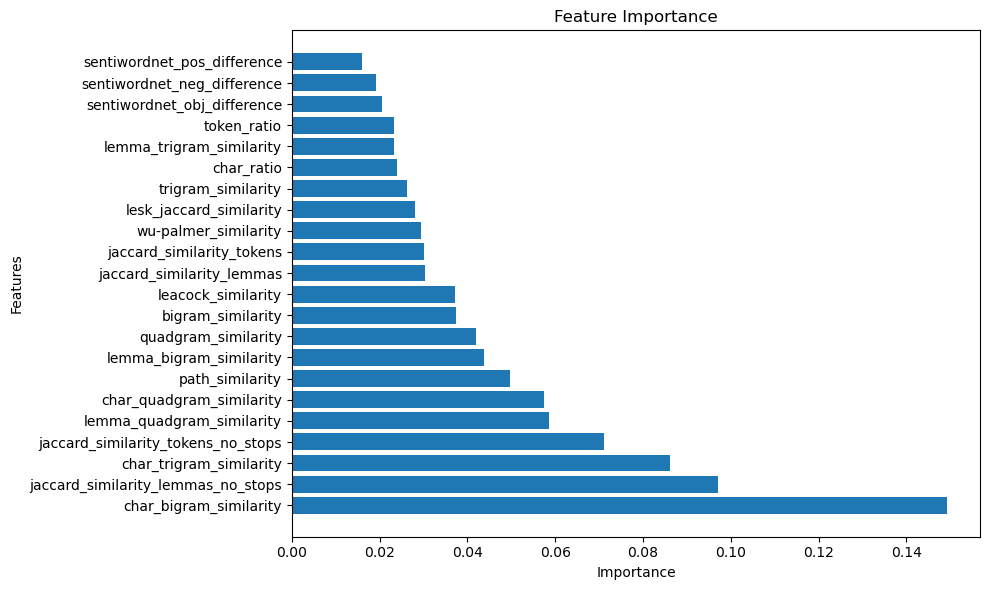

In [103]:
features_importance = pd.DataFrame()
features_importance['feature'] = features_training.columns
features_importance['importance'] = grid_search.feature_importances_

# Sort the features by importance
sorted_features_importance = features_importance.sort_values(by='importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_importance['feature'], sorted_features_importance['importance'])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [104]:
# Dataset names
dataset_names = [path.replace('../Data/Test/test-gold/STS.input.','').replace('.txt','') for path in sentences_file_paths_testing]

features_list_testing

# Testing the model on each dataset
for i, features in enumerate(features_list_testing):
    predictions = grid_search.predict(features)
    pearson_correlation = pearsonr(np.ravel(gs_list_testing[i]), predictions)[0]
    print(f"Testing pearson correlation on {dataset_names[i]}: {pearson_correlation}")

# Testing the model on all datasets
predictions = grid_search.predict(pd.concat(features_list_testing))
pearson_correlation = pearsonr(np.ravel(pd.concat(gs_list_testing)), predictions)[0]
print(f"Testing pearson correlation on all datasets: {pearson_correlation}")

Testing pearson correlation on SMTeuroparl: 0.5944103137612851
Testing pearson correlation on MSRvid: 0.8235976153054372
Testing pearson correlation on MSRpar: 0.6044210738571718
Testing pearson correlation on surprise.OnWN: 0.6896996286116368
Testing pearson correlation on surprise.SMTnews: 0.5721989890168269
Testing pearson correlation on all datasets: 0.704005529041593


## Course of actions
- Added Jaccard
- Tried Removing char_quadgram_similarity, char_trigram_similarity and quadgram_similarity for XGBoost and it improved something the accuracy, but not enough
- Random Forest already performs better without changing anything
- Tried removing the test set for Random Forest in the train dataset
  - Didn't improve in everything
- Trying to pivot the grid search of Random Forest around the best parameters
  - Worse Results -> Will try to add new features
- Adding ngram similarities for lemmas
- Reran everything
  - Performance got worse
- Fixed Leacock, dropped Lin
- Current results:
  - Testing pearson correlation on SMTeuroparl: 0.6105874015394948
  - Testing pearson correlation on MSRvid: 0.8207714940489792
  - Testing pearson correlation on MSRpar: 0.5867962721152671
  - Testing pearson correlation on surprise.OnWN: 0.6900756885799122
  - Testing pearson correlation on surprise.SMTnews: 0.5602905346667665
  - Testing pearson correlation on all datasets: 0.6930512962767175
- To try and improve on this I will perform oversampling on the training instances from SMTeuroparl and MSRpar 
  - Worse results after adding 300 training samples from these datasets twice to the training set
- Added Lesk Similarity
- Added SentiWordNet positive, negative and objective score

https://github.com/nltk/nltk_data/issues/185 : "the information_content() function in wordnet.py is not yet handling adjective satellites. So it is a nltk/nltk issue, because nothing needs to be changed in nltk_data." 

# RBF

In [105]:
from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for the SVM regressor with non-linear kernels
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.1, 0.2, 0.5],
#     'kernel': ['rbf', 'poly', 'sigmoid'],
#     'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
# }

# # Initialize the SVR model
# svr = SVR()

# # Set up the grid search
# grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# best SVR found
grid_search_svr = SVR(C=100, degree=2, epsilon=0.5, kernel='poly')

# Fit the grid search to the data
grid_search_svr.fit(features_training, gs_training)

# # Print the best parameters and the best score
# print(f"Best parameters for SVR: {grid_search_svr.best_params_}")

SVR(C=100, degree=2, epsilon=0.5, kernel='poly')

In [107]:
# Dataset names
dataset_names = [path.replace('../Data/Test/test-gold/STS.input.','').replace('.txt','') for path in sentences_file_paths_testing]

features_list_testing

# Testing the model on each dataset
for i, features in enumerate(features_list_testing):
    predictions = grid_search_svr.predict(features)
    pearson_correlation = pearsonr(np.ravel(gs_list_testing[i]), predictions)[0]
    print(f"Testing pearson correlation on {dataset_names[i]}: {pearson_correlation}")

# Testing the model on all datasets
predictions = grid_search_svr.predict(pd.concat(features_list_testing))
pearson_correlation = pearsonr(np.ravel(pd.concat(gs_list_testing)), predictions)[0]
print(f"Testing pearson correlation on all datasets: {pearson_correlation}")

Testing pearson correlation on SMTeuroparl: 0.4818292080298053
Testing pearson correlation on MSRvid: 0.7937968352351317
Testing pearson correlation on MSRpar: 0.5469670040915136
Testing pearson correlation on surprise.OnWN: 0.6246274546618215
Testing pearson correlation on surprise.SMTnews: 0.44307716423885324
Testing pearson correlation on all datasets: 0.6948334409260908
